In [6]:
import pandas as pd
import numpy as np

from glob import glob
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
from PIL import Image

plt.style.use('ggplot')

In [7]:
img_fns = glob("./images/*")

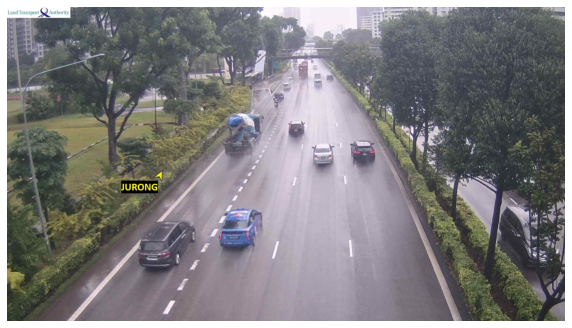

In [8]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(plt.imread(img_fns[0]))
ax.axis('off')
plt.show()

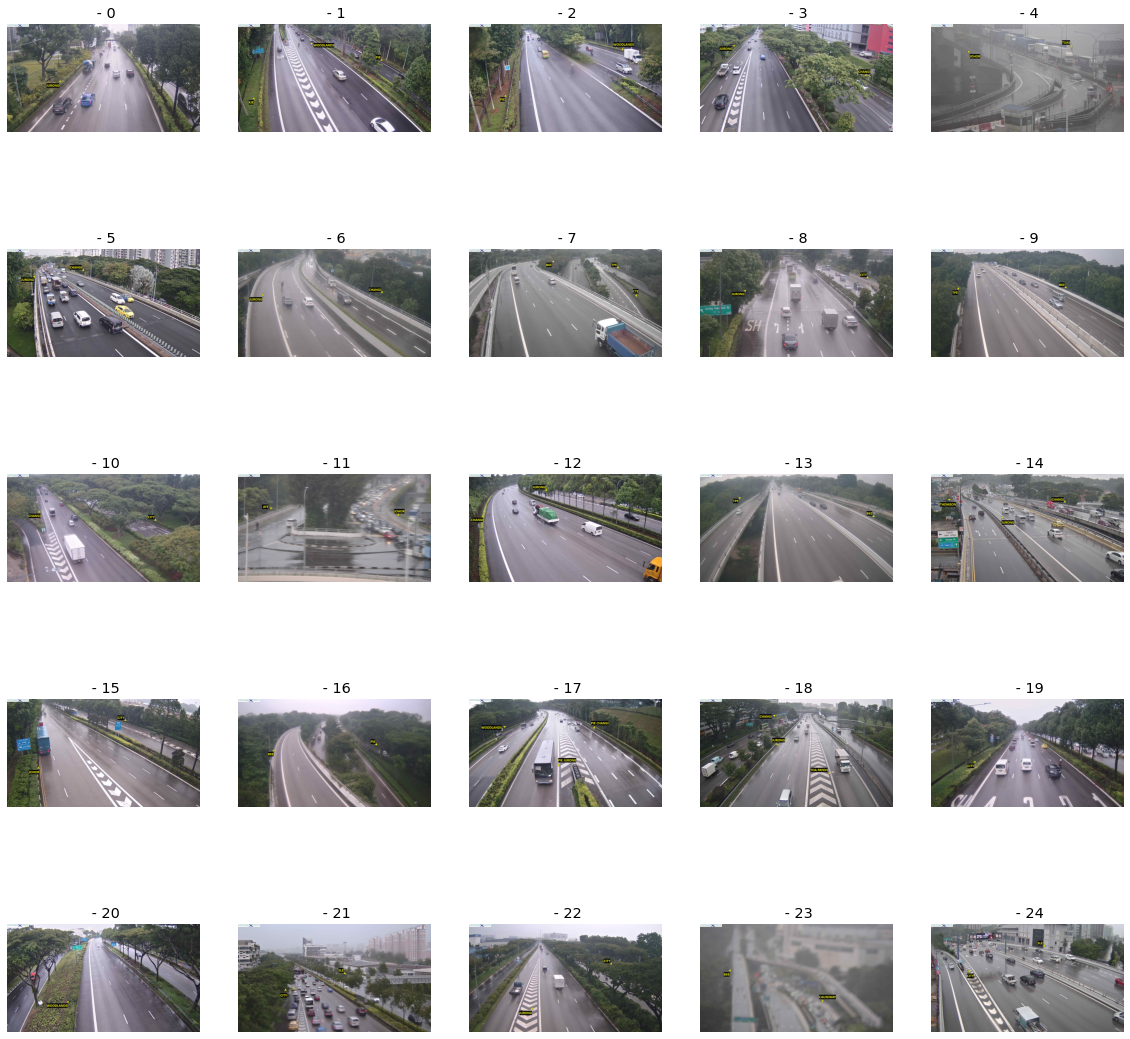

In [9]:
fig, axs = plt.subplots(5, 5, figsize=(20, 20))
axs = axs.flatten()
for i in range(25):
    axs[i].imshow(plt.imread(img_fns[i]))
    axs[i].axis('off')
    image_id = img_fns[i].split('.')[-1].split('/')[-1].rstrip('.jpg')
    axs[i].set_title(f'{image_id} - {i}')
plt.show()

In [10]:
img_fns[0].split(".")

['', '/images/4714_20221007T054552', 'jpg']

easyocr

In [11]:
import easyocr

In [12]:
import keras_ocr

pipeline = keras_ocr.pipeline.Pipeline()

Looking for /Users/chuamingfeng/.keras-ocr/craft_mlt_25k.h5
Looking for /Users/chuamingfeng/.keras-ocr/crnn_kurapan.h5


In [13]:
lta = ["land", "transport", "authority"]

In [14]:
# [[label, array], [label, array]]
results = pipeline.recognize([img_fns[0]])
filtered_results = []
for img in results:
    new_labels = []
    for label in img:
        if label[0].lower() not in lta:
            new_labels.append(label)
    filtered_results.append(new_labels)

1/1 [==============================] - 3s 3s/step


In [15]:
pd.DataFrame(filtered_results[0], columns=['text', 'bbox'])

text                                               bbox
0  jurong  [[389.524, 603.78986], [521.08575, 601.56], [5...

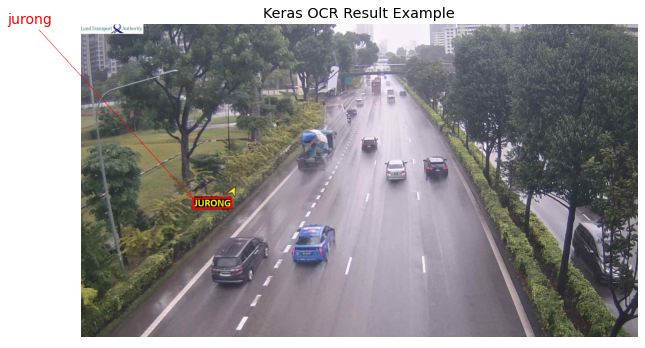

In [16]:
fig, ax = plt.subplots(figsize=(10, 10))
keras_ocr.tools.drawAnnotations(plt.imread(img_fns[0]), filtered_results[0], ax=ax)
ax.set_title('Keras OCR Result Example')
plt.show()

Processing for all images

In [17]:
results = pipeline.recognize(img_fns[:10])

3/3 [==============================] - 5s 1s/step


In [18]:
filtered_results = []
for img in results:
    new_labels = []
    for label in img:
        if label[0].lower() not in lta:
            new_labels.append(label)
    filtered_results.append(new_labels)

In [50]:
# easyocr
reader = easyocr.Reader(['en'], gpu = True)
dfs = []
for img in img_fns[:25]:
    result = reader.readtext(img)
    
    filtered_results = []
    for labels in result:
        new_labels = []
        label = labels[1].split()
        if any(x.lower() in label for x in lta):
            continue
        else:
            new_labels.append(labels)
    filtered_results.append(new_labels)
    result = filtered_results[0]
    
    img_id = img.split(".")[1].split("/")[-1]
    img_df = pd.DataFrame(result, columns=['bbox','text','conf'])
    img_df['img_id'] = img_id
    dfs.append(img_df)
easyocr_df = pd.concat(dfs)

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


In [46]:
test[0]

([[1, 10], [113, 10], [113, 30], [1, 30]], 'Land Transport', 0.808546576875596)

In [38]:
for label in test:
    print(label)

([[1, 10], [113, 10], [113, 30], [1, 30]], 'Land Transport', 0.808546576875596)
([[143, 9], [217, 9], [217, 29], [143, 29]], 'Authority', 0.9974078662992291)
([[388, 600], [523, 600], [523, 640], [388, 640]], 'JURONG', 0.9999482180227424)


In [20]:
# keras
dfs = []
for img in img_fns[:25]:
    img_id = img.split(".")[1].split("/")[-1]
    results = pipeline.recognize([img])
    filtered_results = []
    for img in results:
        new_labels = []
        for label in img:
            if label[0].lower() not in lta:
                new_labels.append(label)
        filtered_results.append(new_labels)
    result = filtered_results[0]
    img_df = pd.DataFrame(result, columns=['text', 'bbox'])
    img_df['img_id'] = img_id
    dfs.append(img_df)
kerasocr_df = pd.concat(dfs)

1/1 [==============================] - 0s 439ms/step


In [21]:
display(kerasocr_df)

text                                               bbox  \
0      jurong  [[389.524, 603.78986], [521.08575, 601.56], [5...   
0   woodlands  [[751.875, 204.375], [958.125, 204.375], [958....   
1        ipie  [[189.375, 270.0], [221.25, 270.0], [221.25, 2...   
2         rie  [[165.0, 273.75], [189.375, 273.75], [189.375,...   
3        slow  [[386.2728, 326.45578], [462.00455, 318.04117]...   
..        ...                                                ...   
0         bke  [[236.25, 495.0], [296.25, 495.0], [296.25, 52...   
1    causeway  [[1183.125, 718.125], [1353.75, 718.125], [135...   
0         sle  [[1059.375, 183.75], [1113.75, 183.75], [1113....   
1        city  [[358.125, 510.0], [427.5, 510.0], [427.5, 538...   
2         cie  [[425.97217, 653.7548], [514.2201, 611.1524], ...   

                  img_id  
0   4714_20221007T054552  
0   2708_20221007T054652  
1   2708_20221007T054652  
2   2708_20221007T054652  
3   2708_20221007T054652  
..                   ...  
0   2702_20221007T054621  
1   2702_20221007T054621  
0   1709_20221007T054646  
1   1709_20221007T054646  
2   1709_20221007T054646  

[90 rows x 3 columns]

In [31]:
def plot_compare(img_fn, easyocr_df, kerasocr_df):
    img_id = img_fn.split(".")[1].split("/")[-1]
    fig, axs = plt.subplots(1, 2, figsize=(15, 10))

    easy_results = easyocr_df.query('img_id == @img_id')[['text','bbox']].values.tolist()
    easy_results = [(x[0], np.array(x[1])) for x in easy_results]
    keras_ocr.tools.drawAnnotations(plt.imread(img_fn), 
                                    easy_results, ax=axs[0])
    axs[0].set_title('easyocr results', fontsize=24)

    keras_results = kerasocr_df.query('img_id == @img_id')[['text','bbox']].values.tolist()
    keras_results = [(x[0], np.array(x[1])) for x in keras_results]
    keras_ocr.tools.drawAnnotations(plt.imread(img_fn), 
                                    keras_results, ax=axs[1])
    axs[1].set_title('keras_ocr results', fontsize=24)
    plt.show()

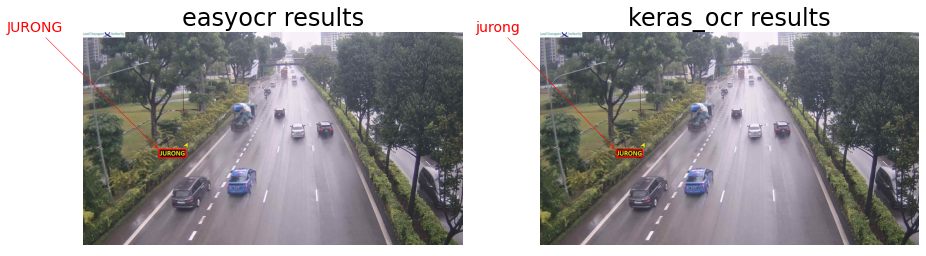

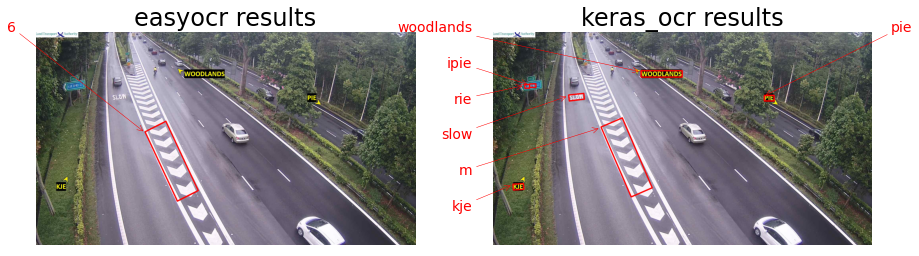

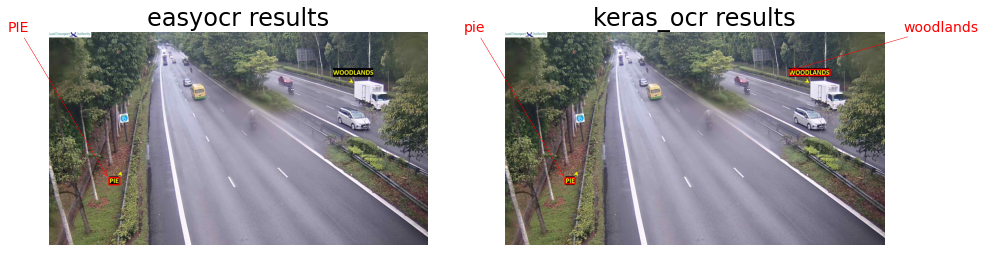

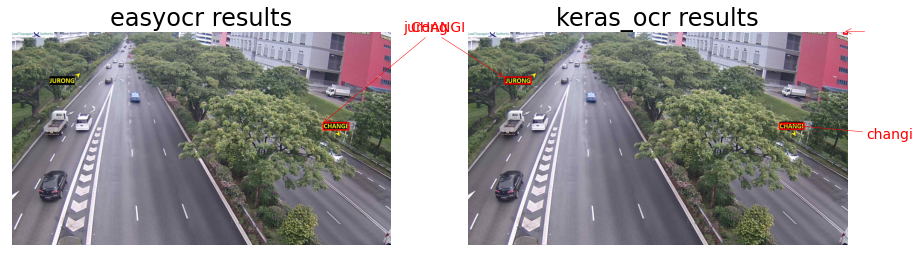

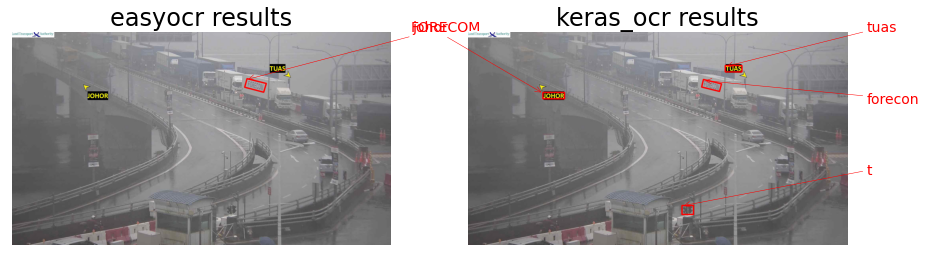

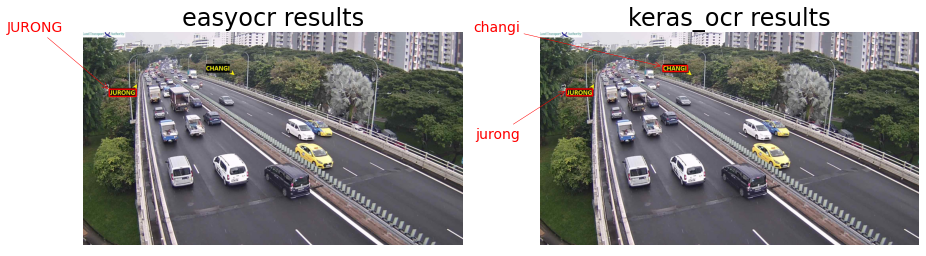

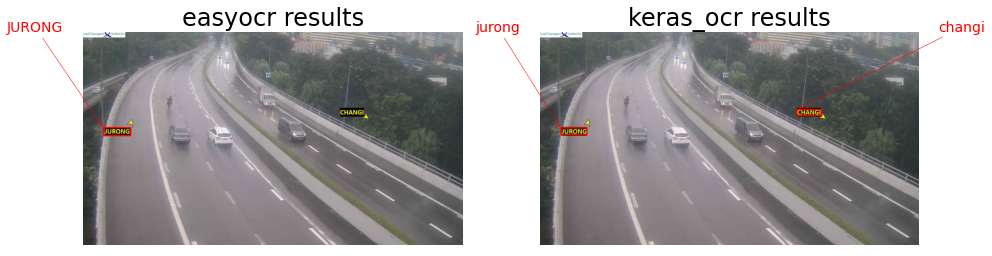

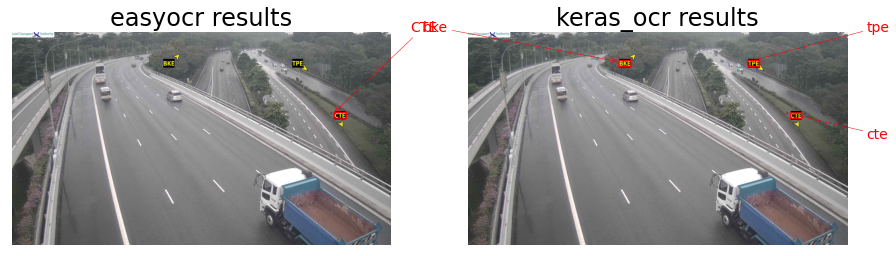

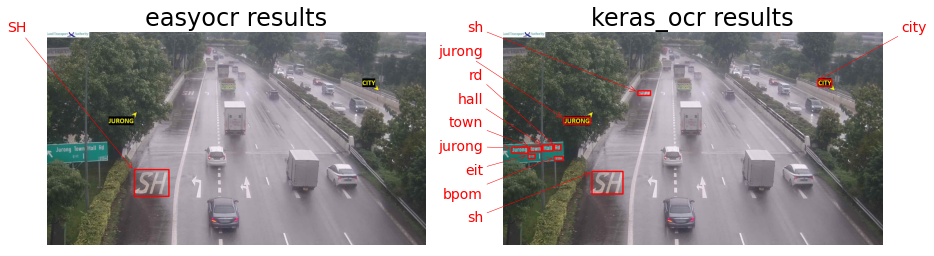

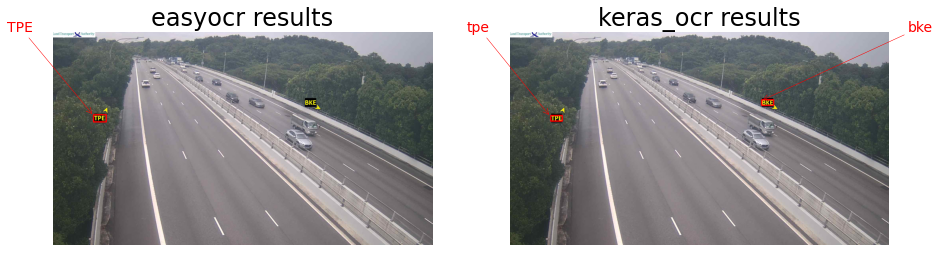

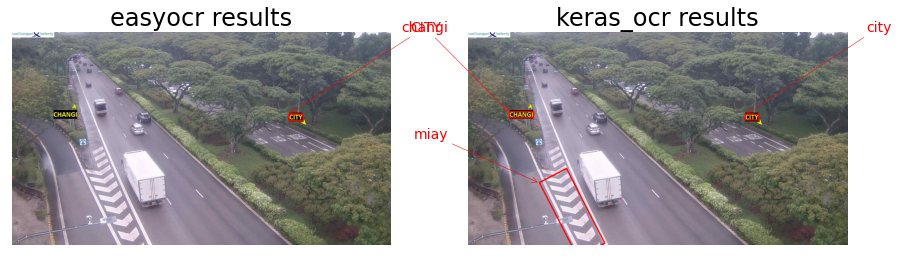

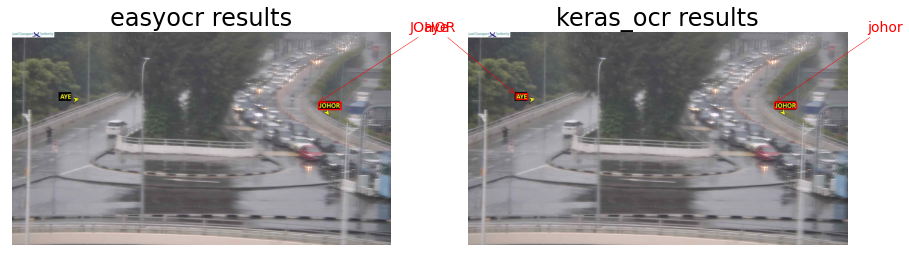

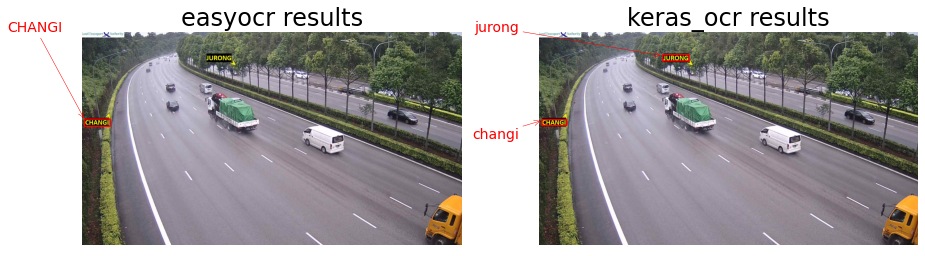

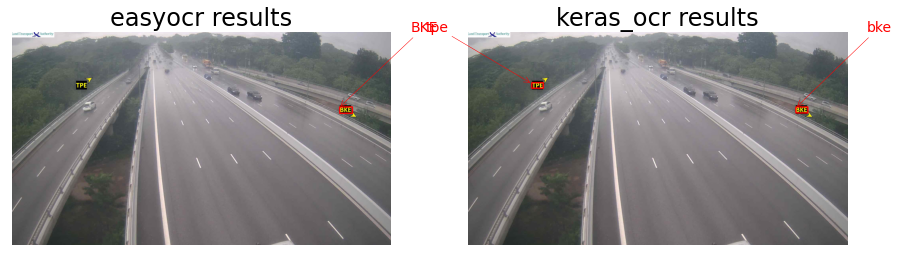

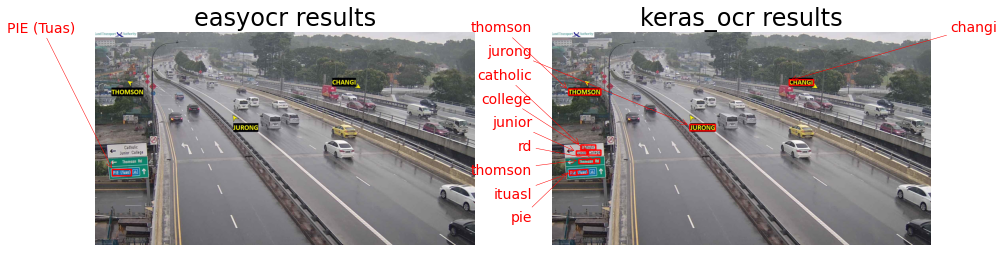

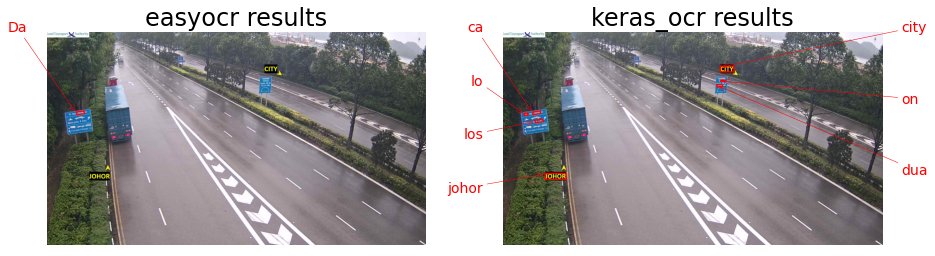

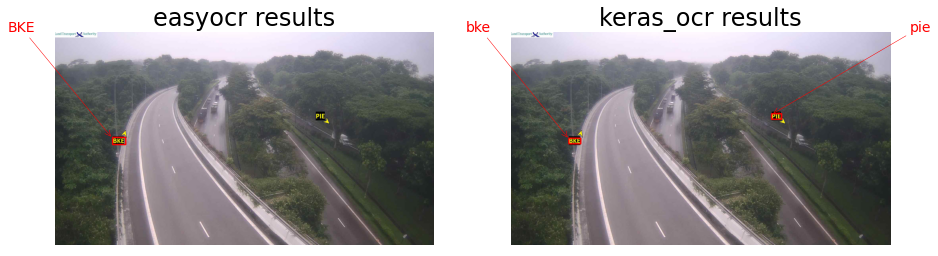

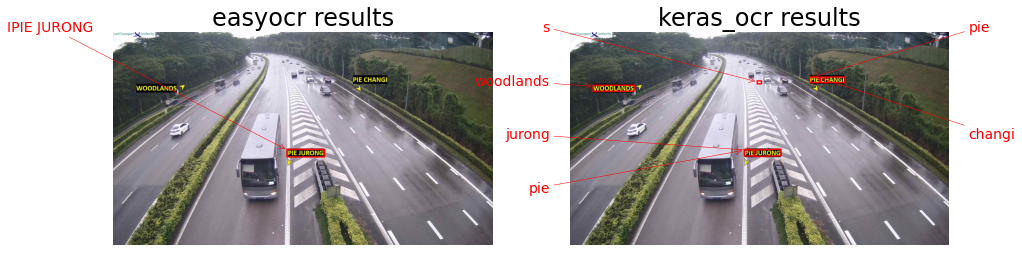

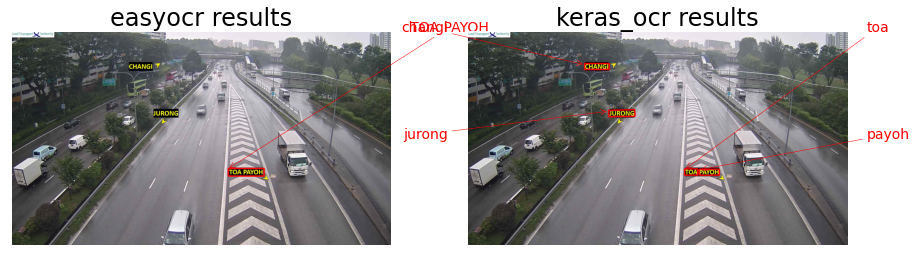

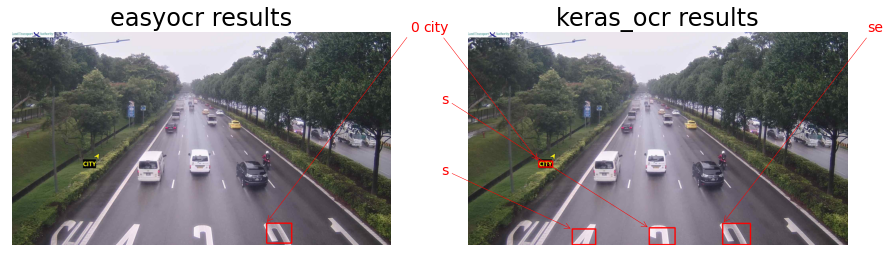

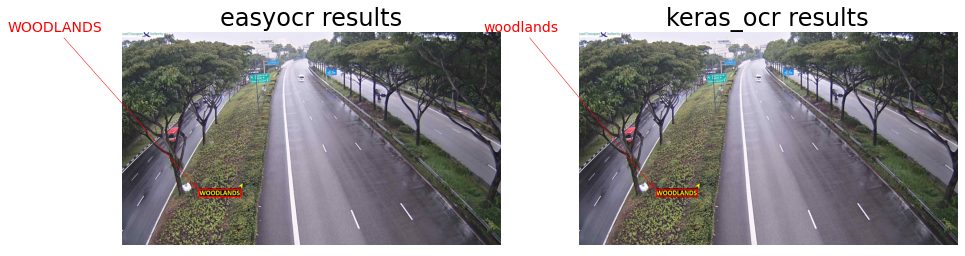

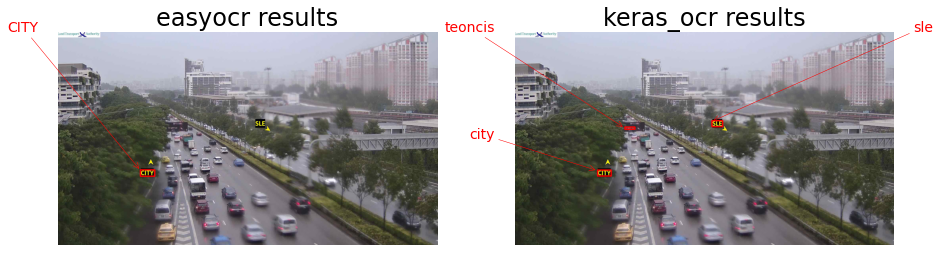

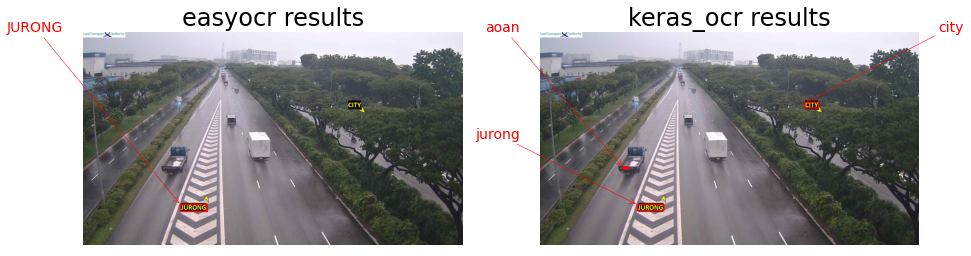

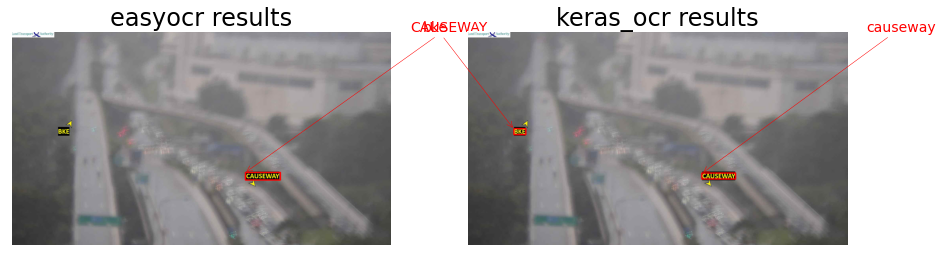

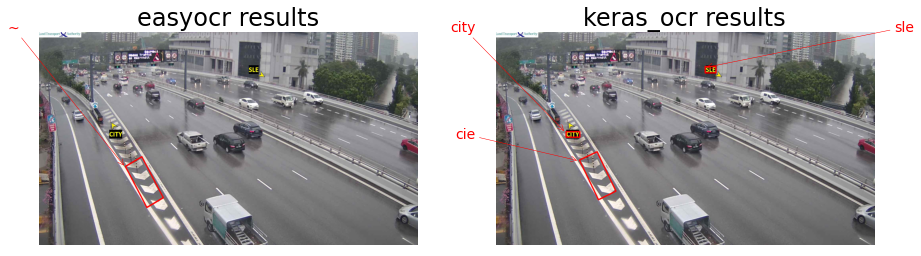

In [51]:
for img_fn in img_fns[:25]:
    plot_compare(img_fn, easyocr_df, kerasocr_df)

In [24]:
kerasocr_df.query('img_id == @img_id')[['text','bbox']].values.tolist()

[['sle',
  array([[1059.375,  183.75 ],
         [1113.75 ,  183.75 ],
         [1113.75 ,  215.625],
         [1059.375,  215.625]], dtype=float32)],
 ['city',
  array([[358.125, 510.   ],
         [427.5  , 510.   ],
         [427.5  , 538.125],
         [358.125, 538.125]], dtype=float32)],
 ['cie',
  array([[425.97217, 653.7548 ],
         [514.2201 , 611.1524 ],
         [609.9301 , 809.4088 ],
         [521.6821 , 852.0112 ]], dtype=float32)]]

In [25]:
img_fns[0].split(".")[1].split("/")[-1]

'4714_20221007T054552'

In [26]:
for img in img_fns[:2]:
    print(img)
    print(type(img.split(".")[1].split("/")[-1]))

./images/4714_20221007T054552.jpg
<class 'str'>
./images/2708_20221007T054652.jpg
<class 'str'>


In [34]:
test = reader.readtext(img_fns[0])